In [0]:
#Importar librerias 
import pandas as pd
import io as io
import numpy as np
import scipy as sp
import seaborn as sns 
from scipy import stats 
from sklearn.externals import joblib
from sklearn.metrics.pairwise import cosine_similarity
import operator

%matplotlib inline

In [2]:
!pip install pandas

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
#Lectura de los csv de drive
users = pd.read_csv('/content/drive/My Drive/ML/users_cleaned.csv')
anime = pd.read_csv('/content/drive/My Drive/ML/anime_cleaned.csv')
rating = pd.read_csv('/content/drive/My Drive/ML/animelists_cleaned.csv')

In [5]:
#Datos que contiene el Dataframe users
users.head()

,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes
0,karthiga,2255153,3,49,1,0,0,55.091667,Female,"Chennai, India",1990-04-29 00:00:00,NaN,2013-03-03 00:00:00,2014-02-04 01:32:00,7.43,0.0,3391
1,Damonashu,37326,45,195,27,25,59,82.574306,Male,"Detroit,Michigan",1991-08-01 00:00:00,NaN,2008-02-13 00:00:00,2017-07-10 06:52:54,6.15,6.0,4903
2,bskai,228342,25,414,2,5,11,159.483333,Male,"Nayarit, Mexico",1990-12-14 00:00:00,NaN,2009-08-31 00:00:00,2014-05-12 16:35:00,8.27,1.0,9701
3,terune_uzumaki,327311,5,5,0,0,0,11.394444,Female,"Malaysia, Kuantan",1998-08-24 00:00:00,NaN,2010-05-10 00:00:00,2012-10-18 19:06:00,9.70,6.0,697
4,Bas_G,5015094,35,114,6,20,175,30.458333,Male,"Nijmegen, Nederland",1999-10-24 00:00:00,NaN,2015-11-26 00:00:00,2018-05-10 20:53:37,7.86,0.0,1847


In [6]:
# Nos quedamos solo con su username y id
users.drop(columns = ['user_watching','user_completed','user_onhold','user_dropped','user_plantowatch','user_days_spent_watching','gender','location',
                      'birth_date','access_rank','join_date','last_online','stats_mean_score','stats_rewatched','stats_episodes'], inplace = True)
users.head()  

,username,user_id
0,karthiga,2255153
1,Damonashu,37326
2,bskai,228342
3,terune_uzumaki,327311
4,Bas_G,5015094


In [7]:
# Datos que contiene el Data Frame Rating
rating.head()

,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags
0,karthiga,21,586,0000-00-00,0000-00-00,9,1,NaN,0,2013-03-03 10:52:53,NaN
1,karthiga,59,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-03-10 13:54:51,NaN
2,karthiga,74,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-04-27 16:43:35,NaN
3,karthiga,120,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-03-03 10:53:57,NaN
4,karthiga,178,26,0000-00-00,0000-00-00,7,2,0.0,0,2013-03-27 15:59:13,NaN


In [8]:
#Nos quedamos con los atributos que nos interesan de cada Data Frame
rating.drop(columns=['my_watched_episodes', 'my_start_date', 'my_finish_date', 'my_status', 'my_rewatching', 'my_rewatching_ep', 'my_last_updated', 'my_tags'], inplace = True)
rating.my_score.replace({0: np.nan}, regex=True, inplace = True)
rating.head()

,username,anime_id,my_score
0,karthiga,21,9.0
1,karthiga,59,7.0
2,karthiga,74,7.0
3,karthiga,120,7.0
4,karthiga,178,7.0


In [9]:
# Vemos que los puntajes de cada usuario caen dentro del intervalo {0,1,2,3,...,10}
rating['my_score'].value_counts()

8.0     4834595
7.0     4234726
9.0     3443674
10.0    2507404
6.0     2128502
5.0     1085660
4.0      480871
3.0      223202
2.0      130314
1.0      103177
Name: my_score, dtype: int64

In [10]:
# anime_id	name	genre	type	episodes	rating	members
anime = anime.drop(columns = ['title_english', 'title_japanese', 'title_synonyms', 'image_url', 'status', 'airing', 'aired_string', 'aired', 'duration', 'rating', 'rank','popularity', 'members']) 
anime = anime.drop(columns = ['favorites', 'background', 'premiered', 'broadcast', 'related', 'producer', 'licensor', 'studio', 'opening_theme', 'ending_theme', 'duration_min', 'aired_from_year'])
anime.head()

,anime_id,title,type,source,episodes,score,scored_by,genre
0,11013,Inu x Boku SS,TV,Manga,12,7.63,139250,"Comedy, Supernatural, Romance, Shounen"
1,2104,Seto no Hanayome,TV,Manga,26,7.89,91206,"Comedy, Parody, Romance, School, Shounen"
2,5262,Shugo Chara!! Doki,TV,Manga,51,7.55,37129,"Comedy, Magic, School, Shoujo"
3,721,Princess Tutu,TV,Original,38,8.21,36501,"Comedy, Drama, Magic, Romance, Fantasy"
4,12365,Bakuman. 3rd Season,TV,Manga,25,8.67,107767,"Comedy, Drama, Romance, Shounen"


In [11]:
#Por ejemplo los animes pueden basarse en :
anime['source'].value_counts()

Manga            2493
Original         1789
Light novel       512
Visual novel      482
Game              424
Novel             282
4-koma manga      194
Other             170
Web manga         111
Music              55
Picture book       53
Card game          46
Book               45
Digital manga       7
Radio               5
Name: source, dtype: int64

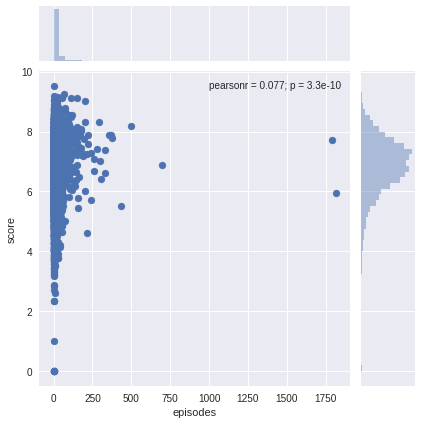

In [12]:
# Ploteamos la cantidad de episodios vs score 
sns.jointplot(x='episodes', y='score', data=anime)

In [13]:
# Apreciamos la presencia de animes con una cantidad de episodios muy alta
anime[(anime.episodes > 250)].sort_values(by='episodes', ascending=False)

,anime_id,title,type,source,episodes,score,scored_by,genre
5572,12393,Oyako Club,TV,Original,1818,5.96,108,"Slice of Life, Comedy"
5394,2471,Doraemon (1979),TV,Manga,1787,7.73,7903,"Adventure, Comedy, Fantasy, Kids, Sci-Fi, Shounen"
942,4936,Ninja Hattori-kun,TV,Manga,694,6.90,1486,"Slice of Life, Comedy, Martial Arts, Shounen"
17,1735,Naruto: Shippuuden,TV,Manga,500,8.18,385179,"Action, Adventure, Comedy, Super Power, Martia..."
5043,10797,Kayoe! Chuugaku,TV,Original,431,5.50,10,"Comedy, School"
1367,3545,Kochira Katsushikaku Kameari Kouenmae Hashutsu...,TV,Manga,373,7.79,1975,"Slice of Life, Comedy, Police"
14,269,Bleach,TV,Manga,366,7.90,433097,"Action, Adventure, Comedy, Super Power, Supern..."
3209,516,Keroro Gunsou,TV,Manga,358,7.88,11420,"Comedy, Mecha, Parody, Sci-Fi, Shounen"
3689,6509,Kiteretsu Daihyakka,TV,Manga,331,6.63,709,"Comedy, Drama, Kids, Slice of Life"
3942,3006,Atashin&#039;chi,TV,Manga,330,7.39,580,"Comedy, Slice of Life"


In [14]:
# Filtramos los animes que solo son de TV
anime_tv = anime[anime['type']=='TV']
anime_tv.head()

,anime_id,title,type,source,episodes,score,scored_by,genre
0,11013,Inu x Boku SS,TV,Manga,12,7.63,139250,"Comedy, Supernatural, Romance, Shounen"
1,2104,Seto no Hanayome,TV,Manga,26,7.89,91206,"Comedy, Parody, Romance, School, Shounen"
2,5262,Shugo Chara!! Doki,TV,Manga,51,7.55,37129,"Comedy, Magic, School, Shoujo"
3,721,Princess Tutu,TV,Original,38,8.21,36501,"Comedy, Drama, Magic, Romance, Fantasy"
4,12365,Bakuman. 3rd Season,TV,Manga,25,8.67,107767,"Comedy, Drama, Romance, Shounen"


In [15]:
rating.rename(columns= {'my_score' : 'score', 'used_id' : 'username'}, inplace = True)
rating.head()

,username,anime_id,score
0,karthiga,21,9.0
1,karthiga,59,7.0
2,karthiga,74,7.0
3,karthiga,120,7.0
4,karthiga,178,7.0


In [16]:
# Unimos los dos Data Frames
merged = rating.merge(anime_tv, left_on = 'anime_id', right_on = 'anime_id', suffixes= ['_user', ''])
merged.drop(columns=['episodes','score','scored_by'], inplace = True)
merged.head()

,username,anime_id,score_user,title,type,source,genre
0,karthiga,21,9.0,One Piece,TV,Manga,"Action, Adventure, Comedy, Super Power, Drama,..."
1,Damonashu,21,10.0,One Piece,TV,Manga,"Action, Adventure, Comedy, Super Power, Drama,..."
2,bskai,21,8.0,One Piece,TV,Manga,"Action, Adventure, Comedy, Super Power, Drama,..."
3,Slimak,21,10.0,One Piece,TV,Manga,"Action, Adventure, Comedy, Super Power, Drama,..."
4,MistButterfly,21,NaN,One Piece,TV,Manga,"Action, Adventure, Comedy, Super Power, Drama,..."


In [17]:
merged.shape

(22183144, 7)

In [18]:
# Filtramos la informacion que nos interesa de la tabla
merged = merged[['username', 'title', 'score_user']]
merged = merged.merge(users, left_on = 'username', right_on = 'username')
merged.head()

,username,title,score_user,user_id
0,karthiga,One Piece,9.0,2255153
1,karthiga,Chobits,7.0,2255153
2,karthiga,Gakuen Alice,7.0,2255153
3,karthiga,Fruits Basket,7.0,2255153
4,karthiga,Ultra Maniac,7.0,2255153


In [19]:
merged.shape

(22183144, 4)

In [20]:
# Nos quedamos con 10^4 usuarios para agilizar los calculos
# Experimentalmente con esta cantidad de datos no da RTE
data = merged[merged.user_id <= 500000]
data.drop(columns = ['username'], inplace = True)
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,title,score_user,user_id
53,One Piece,10.0,37326
54,Cardcaptor Sakura,NaN,37326
55,InuYasha,4.0,37326
56,Bleach,2.0,37326
57,Ouran Koukou Host Club,6.0,37326


In [0]:
piv = data.pivot_table(index=['user_id'], columns=['title'], values='score_user')

In [0]:
print(piv.shape)
piv.head()

In [0]:
# Normalizamos los puntajes de cada usuario z = (x - u) / sigma
piv_norm = piv.apply(lambda x: (x-np.mean(x))/(np.std(x)), axis=1)

# Quitamos todas las filas con solo ceros ya que son usuarios que no puntuaron nada
piv_norm.fillna(0, inplace=True)
piv_norm = piv_norm.T
piv_norm = piv_norm.loc[:, (piv_norm != 0).any(axis=0)]

In [0]:
# Guardamos en piv_sparse una Compressed Sparse Row matrix (csr) que permitie realizar opearaciones aritmeticas mas eficientes
piv_sparse = sp.sparse.csr_matrix(piv_norm.values)

In [0]:
# En los siguientes arreglos guardamos la similitud entre los animes 2 a 2 asi como de los usuarios 2 a 2
item_similarity = cosine_similarity(piv_sparse)
user_similarity = cosine_similarity(piv_sparse.T)

In [0]:
# Inserting the similarity matricies into dataframe objects

item_sim_df = pd.DataFrame(item_similarity, index = piv_norm.index, columns = piv_norm.index)
user_sim_df = pd.DataFrame(user_similarity, index = piv_norm.columns, columns = piv_norm.columns)

In [0]:
# Guardamos en pickles la informacion necesaria para hacer las predicciones
# item_sim_df
# user_sim_df
# piv_norm

def savePickle(file,name):
  joblib.dump(file, name + '.pkl') 

def readPickle(name):
  data = joblib.load(name + '.pkl')
  return data

In [0]:
# Guardar pickles
savePickle(item_sim_df,'item_sim_df')
savePickle(user_sim_df,'user_sim_df')
savePickle(piv_norm,'piv_norm')

In [0]:
# Leer pickles
item_sim_df = readPickle('item_sim_df')
user_sim_df = readPickle('user_sim_df')
piv_norm = readPickle('piv_norm')

In [0]:
# Esta funcion imprime los 10 animes con mas similitud
def top_animes(anime_name):
    count = 1
    print('Similar shows to {} include:\n'.format(anime_name))
    for item in item_sim_df.sort_values(by = anime_name, ascending = False).index[1:11]:
        print('No. {}: {}'.format(count, item))
        count +=1  

In [0]:
# Esta funcion retorna los 5 usuarios con mas similitud
def top_users(user):
    
    if user not in piv_norm.columns:
        return('No data available on user {}'.format(user))
    
    print('Most Similar Users:\n')
    sim_values = user_sim_df.sort_values(by=user, ascending=False).loc[:,user].tolist()[1:11]
    sim_users = user_sim_df.sort_values(by=user, ascending=False).index[1:11]
    zipped = zip(sim_users, sim_values,)
    for user, sim in zipped:
        print('User #{0}, Similarity value: {1:.2f}'.format(user, sim)) 

In [0]:
# Esta funcion devuelve una lista de listas que contienen los animes con mas rating por cada usuario
# y retorna los animes con la frecuencia con la que aparecen en la lista
def similar_user_recs(user):
    
    if user not in piv_norm.columns:
        return('No data available on user {}'.format(user))
    
    sim_users = user_sim_df.sort_values(by=user, ascending=False).index[1:11]
    best = []
    most_common = {}
    
    for i in sim_users:
        max_score = piv_norm.loc[:, i].max()
        best.append(piv_norm[piv_norm.loc[:, i]==max_score].index.tolist())
    for i in range(len(best)):
        for j in best[i]:
            if j in most_common:
                most_common[j] += 1
            else:
                most_common[j] = 1
    sorted_list = sorted(most_common.items(), key=operator.itemgetter(1), reverse=True)
    return sorted_list[:5]   

In [0]:
# Esta funcion toma en cuenta un ponderado de los animes mejor recomendados por otros usuarios
# tomando en cuenta la similitud de estos usuarios con el usuario

def predicted_rating(anime_name, user):
    sim_users = user_sim_df.sort_values(by=user, ascending=False).index[1:1000]
    user_values = user_sim_df.sort_values(by=user, ascending=False).loc[:,user].tolist()[1:1000]
    rating_list = []
    weight_list = []
    for j, i in enumerate(sim_users):
        rating = piv.loc[i, anime_name]
        similarity = user_values[j]
        if np.isnan(rating):
            continue
        elif not np.isnan(rating):
            rating_list.append(rating*similarity)
            weight_list.append(similarity)
    return sum(rating_list)/sum(weight_list)    

In [0]:
top_animes('Cowboy Bebop')

In [0]:
top_users(3)

In [0]:
similar_user_recs(3)

In [0]:
predicted_rating('Cowboy Bebop', 3)

In [0]:
watched = piv.T[piv.loc[3,:]>0].index.tolist()

In [0]:
# Calculamos Sumatoria (prediccion - actual) ^ 2
errors = []
for i in watched:
    actual=piv.loc[3, i]
    predicted = predicted_rating(i, 3)
    errors.append((actual-predicted)**2)

In [0]:
# El error en promedio de todas las predicciones
np.mean(errors)